In [2]:
!pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 38.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.19.2 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [3]:
import cv2
import os
import torch
import random
import pickle
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.applications import VGG16
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.models import load_model, save_model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape, Lambda
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
%matplotlib inline

In [4]:
# разархивируем датасет, который находится на подключенном гугл диске
zip_file = '/content/drive/MyDrive/dataset/archive.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

print(os.listdir())

['.config', 'Test.csv', 'test', 'Train', 'Train.csv', 'meta', 'drive', 'train', 'Test', 'Meta', 'Meta.csv', 'sample_data']


In [5]:
# задаем пути к разархивированным данным
data_path = '/content'
train_data_path = os.path.join(data_path, 'Train')
test_data_path = os.path.join(data_path, 'Test')
meta_data_path = os.path.join(data_path, 'Meta')

data[0]:
 [[[0.0627451  0.08235294 0.10980392]
  [0.05882353 0.07843138 0.11764706]
  [0.06666667 0.09411765 0.11764706]
  ...
  [0.07058824 0.07058824 0.07058824]
  [0.0627451  0.0627451  0.05882353]
  [0.05098039 0.05098039 0.04705882]]

 [[0.07843138 0.10588235 0.13725491]
  [0.12941177 0.11764706 0.16078432]
  [0.18039216 0.14509805 0.16470589]
  ...
  [0.07843138 0.08235294 0.08235294]
  [0.06666667 0.07450981 0.06666667]
  [0.0627451  0.06666667 0.05882353]]

 [[0.33333334 0.31764707 0.31764707]
  [0.34117648 0.26666668 0.31764707]
  [0.4        0.29411766 0.31764707]
  ...
  [0.16078432 0.15686275 0.14117648]
  [0.2        0.16078432 0.14901961]
  [0.1764706  0.14901961 0.14117648]]

 ...

 [[0.59607846 0.5647059  0.58431375]
  [0.6666667  0.627451   0.6392157 ]
  [0.7019608  0.6627451  0.6431373 ]
  ...
  [0.6784314  0.64705884 0.63529414]
  [0.6862745  0.63529414 0.61960787]
  [0.6392157  0.5803922  0.5529412 ]]

 [[0.6156863  0.5686275  0.5764706 ]
  [0.68235296 0.6392157  0.

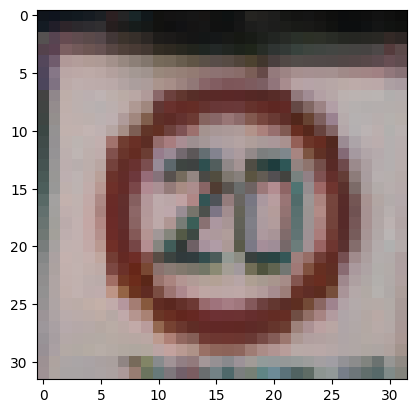

In [6]:
# предобработка
data = []
labels = []
class_count = 43
for i in range(class_count):
    img_path = os.path.join(train_data_path, str(i))
    for img in os.listdir(img_path):
        img = image.load_img(img_path + '/' + img, target_size=(32, 32))
        img_array = image.img_to_array(img)
        img_array = img_array / 255
        data.append(img_array)
        labels.append(i)
data = np.array(data)
labels = np.array(labels)
labels = to_categorical(labels, 43)
# отобразим первый элемент
print("data[0]:\n",data[0])
# отобразим первый элемент в виде картинки
plt.imshow(data[0])


In [7]:
# выполним разделение данных на треннировочный и тестовый набор 70/30
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.3, random_state=1)

# отобразим размерности обучающего и тестового набора и первый элемент
print("training shape: ",x_train.shape, y_train.shape)
print("testing shape: ",x_val.shape, y_val.shape)
print(y_train[0])


training shape:  (27446, 32, 32, 3) (27446, 43)
testing shape:  (11763, 32, 32, 3) (11763, 43)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
# ResNet50
model = Sequential()
model.add(ResNet50(include_top = False, pooling = 'avg'))
model.add(Dropout(0.1))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(43, activation = 'softmax'))
model.layers[2].trainable = False
# отобразим итоговую сводку по модели
print(model.summary())

94765736/94765736 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 43)                11051     
                                                                 
Total params: 24123307 (92.02 MB)
Trainable params: 23545643 (89.82 MB)
Non-trainable params: 577664 (2.20 MB)
____________

 GridSearch для поиска наилучших гиперпараметров.

In [9]:
# обучаем модель в течение 5 эпох, используем оптимизатор Adam и
# функцию потерь categorical crossentropy
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

# сохраним историю обучения для последующего анализа на графиках
history = model.fit(x_train, y_train, validation_data =(x_val, y_val),
                                                    epochs = 5, batch_size = 64)
# сохраняем модель для последующего использования
save_model(model, 'ResNet50.h5')

Epoch 1/5
429/429 [==============================] - 70s 69ms/step - loss: 1.0368 - accuracy: 0.7202 - val_loss: 4.8013 - val_accuracy: 0.0991
Epoch 2/5
429/429 [==============================] - 24s 56ms/step - loss: 0.1899 - accuracy: 0.9477 - val_loss: 0.7516 - val_accuracy: 0.8125
Epoch 3/5
429/429 [==============================] - 22s 50ms/step - loss: 0.1281 - accuracy: 0.9650 - val_loss: 0.2106 - val_accuracy: 0.9498
Epoch 4/5
429/429 [==============================] - 23s 54ms/step - loss: 0.1065 - accuracy: 0.9716 - val_loss: 0.4012 - val_accuracy: 0.9102
Epoch 5/5
429/429 [==============================] - 22s 52ms/step - loss: 0.1190 - accuracy: 0.9728 - val_loss: 0.0973 - val_accuracy: 0.9740


<ipython-input-9-4c0b50d40adf>:9: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'ResNet50.h5')


In [10]:
# загрузка тестовых данных из CSV файла
test = pd.read_csv("Test.csv")
test_imgs = test['Path'].values
data = []

for img in test_imgs:
    img = image.load_img(img, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array / 255
    data.append(img_array)

data = np.array(data)
y_test = test['ClassId'].values.tolist()
y_test = np.array(y_test)
y_test = to_categorical(y_test, 43)


In [11]:
# VGG16
model2 = Sequential()
model2.add(VGG16(include_top=False, pooling = 'avg'))
model2.add(Dropout(0.1))
model2.add(Dense(256, activation="relu"))
model2.add(Dropout(0.1))
model2.add(Dense(43, activation = 'softmax'))
model2.layers[2].trainable = False
# отобразим итоговую сводку по модели
print(model2.summary())

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 43)                11051     
                                                                 
Total params: 14857067 (56.68 MB)
Trainable params: 14725739 (56.17 MB)
Non-trainable params: 131328 (513.00 KB)
________

In [12]:
# обучаем модель в течение 5 эпох, используем оптимизатор Adam и
# функцию потерь categorical crossentropy
model2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
# сохраним историю обучения для последующего анализа на графиках
history2 = model2.fit(x_train, y_train, validation_data =(x_val, y_val),
                                                    epochs = 5, batch_size = 64)
# сохраняем модель для последующего использования
save_model(model2, 'VGG16.h5')

Epoch 1/5
429/429 [==============================] - 27s 47ms/step - loss: 2.6755 - accuracy: 0.2220 - val_loss: 1.2676 - val_accuracy: 0.5261
Epoch 2/5
429/429 [==============================] - 17s 39ms/step - loss: 0.7437 - accuracy: 0.7503 - val_loss: 0.4936 - val_accuracy: 0.8467
Epoch 3/5
429/429 [==============================] - 18s 41ms/step - loss: 0.3165 - accuracy: 0.9053 - val_loss: 0.1725 - val_accuracy: 0.9515
Epoch 4/5
429/429 [==============================] - 17s 39ms/step - loss: 0.1712 - accuracy: 0.9522 - val_loss: 0.2979 - val_accuracy: 0.9305
Epoch 5/5
429/429 [==============================] - 17s 39ms/step - loss: 0.1288 - accuracy: 0.9663 - val_loss: 0.1073 - val_accuracy: 0.9724


<ipython-input-12-91ee56081336>:8: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model2, 'VGG16.h5')


In [13]:
# оценкa производительности 2 моделей на тестовом наборе данных
history_test = model.fit(x_val, y_val, epochs=5, batch_size=64, validation_data=(x_val, y_val))
history2_test = model2.fit(x_val, y_val, epochs=5, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/5
184/184 [==============================] - 13s 72ms/step - loss: 0.1100 - accuracy: 0.9726 - val_loss: 0.1189 - val_accuracy: 0.9668
Epoch 2/5
184/184 [==============================] - 11s 62ms/step - loss: 0.0683 - accuracy: 0.9828 - val_loss: 0.0349 - val_accuracy: 0.9918
Epoch 3/5
184/184 [==============================] - 11s 60ms/step - loss: 0.0546 - accuracy: 0.9854 - val_loss: 0.0480 - val_accuracy: 0.9878
Epoch 4/5
184/184 [==============================] - 10s 55ms/step - loss: 0.0619 - accuracy: 0.9837 - val_loss: 0.2008 - val_accuracy: 0.9443
Epoch 5/5
184/184 [==============================] - 11s 59ms/step - loss: 0.0580 - accuracy: 0.9866 - val_loss: 0.0792 - val_accuracy: 0.9778
Epoch 1/5
184/184 [==============================] - 11s 58ms/step - loss: 0.1821 - accuracy: 0.9575 - val_loss: 0.1200 - val_accuracy: 0.9710
Epoch 2/5
184/184 [==============================] - 9s 49ms/step - loss: 0.1274 - accuracy: 0.9714 - val_loss: 0.0475 - val_accuracy: 0.9878


In [14]:
from tabulate import tabulate
# создаем и выводим таблицу, которая показывает точность
# обоих моделей на треннировочном, валидационном и тестовом наборе данных
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
test_accuracy = history_test.history['accuracy']

train_accuracy2 = history2_test.history['accuracy']
val_accuracy2 = history2_test.history['val_accuracy']
test_accuracy2 = history2_test.history['accuracy']

table = [["Model","Training Accuracy","Validation Accuracy","Test Accuracy"],
            ["Resnet50",train_accuracy[4]*100,val_accuracy[4]*100,test_accuracy[4]*100],
            ["VGG16",train_accuracy2[4]*100,val_accuracy2[4]*100,test_accuracy2[4]*100]]

table1 = tabulate(table,headers="firstrow",tablefmt="grid")
print(table1)


+----------+---------------------+-----------------------+-----------------+
| Model    |   Training Accuracy |   Validation Accuracy |   Test Accuracy |
+==========+=====================+=======================+=================+
| Resnet50 |             97.2783 |               97.3986 |         98.6568 |
+----------+---------------------+-----------------------+-----------------+
| VGG16    |             98.5208 |               98.8523 |         98.5208 |
+----------+---------------------+-----------------------+-----------------+


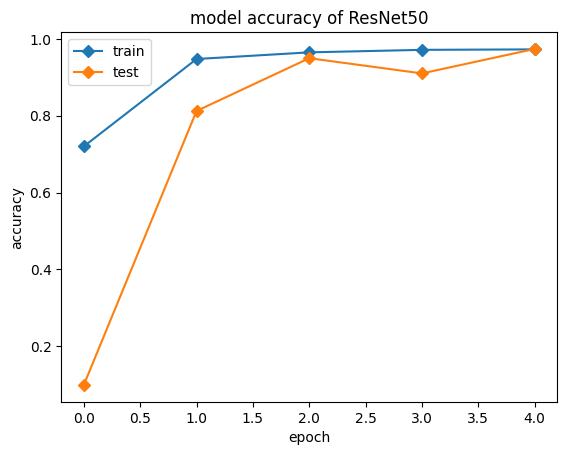

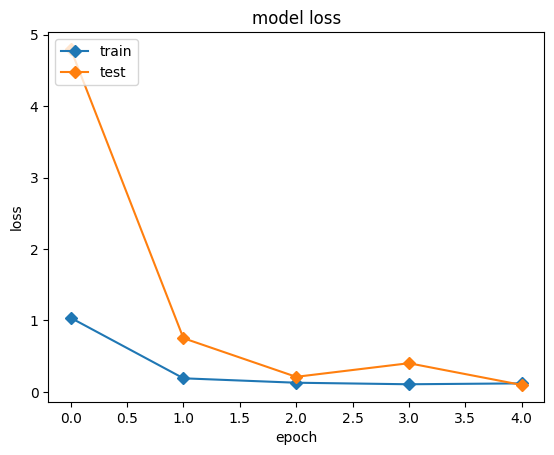

In [15]:
# ResNet50
# графики отражают зависимость метрики от эпохи для тренировочного и тестового наборов
# график точности
plt.plot(history.history['accuracy'], marker='D')
plt.plot(history.history['val_accuracy'], marker='D')
plt.title('model accuracy of ResNet50')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# график потерь
plt.plot(history.history['loss'], marker='D')
plt.plot(history.history['val_loss'], marker='D')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

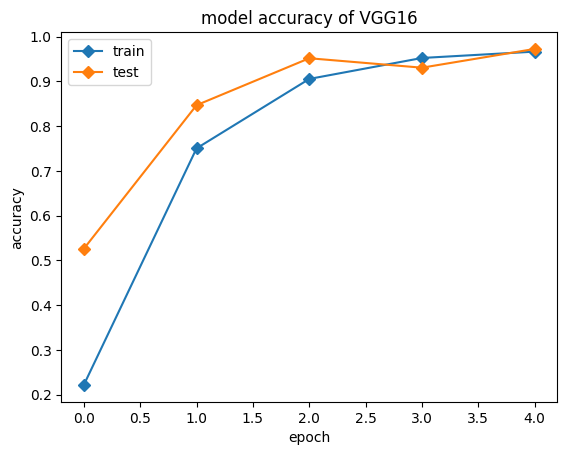

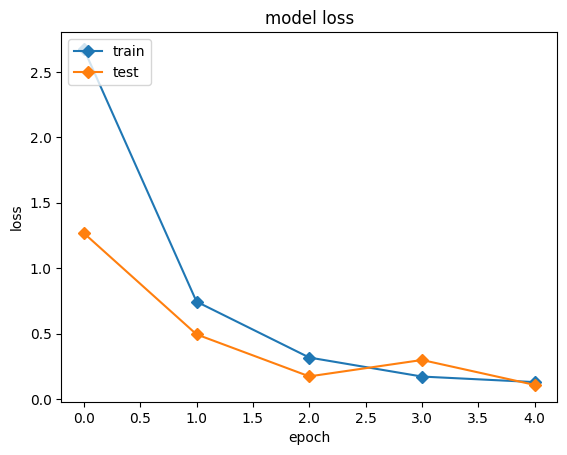

In [16]:
# VGG16
# графики отражают зависимость метрики от эпохи для тренировочного и тестового наборов
# график точности
plt.plot(history2.history['accuracy'], marker='D')
plt.plot(history2.history['val_accuracy'], marker='D')
plt.title('model accuracy of VGG16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# график потерь
plt.plot(history2.history['loss'], marker='D')
plt.plot(history2.history['val_loss'], marker='D')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**ЗАДАНИЕ 2**

In [31]:
# загрузим модель из предыдущего задания и берем тысячу первых элементов
# для проведения операций сразу, без построения графа вычислений
tf.compat.v1.disable_eager_execution()

model=load_model('ResNet50.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))

In [32]:
# создаем атаку FGSM
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = [] # для точности оригинальных данных
adv_accuracises_fgsm = []
true_losses = [] # для потерь на оригинальных данных
adv_losses_fgsm = []

# прохилдимся по диапазону значений eps
for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps}) # уствновка нового значения eps
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, y_test) # генерация адверсариальных
    # примеров для тестового набора данных
    loss, accuracy = model.evaluate(x_test_adv, y_test) # оценка потерь и точности
    adv_accuracises_fgsm.append(accuracy)
    adv_losses_fgsm.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Adv Loss: 1.131294111251831
Adv Accuracy: 0.7850000262260437
True Loss: 0.29480318588018417
True Accuracy: 0.9279999732971191
Eps: 0.00784313725490196
Adv Loss: 2.0588294773101805
Adv Accuracy: 0.6439999938011169
True Loss: 0.29480318588018417
True Accuracy: 0.9279999732971191
Eps: 0.011764705882352941
Adv Loss: 2.9430927171707153
Adv Accuracy: 0.5189999938011169
True Loss: 0.29480318588018417
True Accuracy: 0.9279999732971191
Eps: 0.01568627450980392
Adv Loss: 3.6552466468811033
Adv Accuracy: 0.4339999854564667
True Loss: 0.29480318588018417
True Accuracy: 0.9279999732971191
Eps: 0.0196078431372549
Adv Loss: 4.219589046478271
Adv Accuracy: 0.3799999952316284
True Loss: 0.29480318588018417
True Accuracy: 0.9279999732971191
Eps: 0.03137254901960784
Adv Loss: 5.240649433135986
Adv Accuracy: 0.2809999883174896
True Loss: 0.29480318588018417
True Accuracy: 0.9279999732971191
Eps: 0.0392156862745098
Adv Loss: 5.627641944885254
Adv Accuracy: 0.2409999966621399
True Loss: 0.29480318588018417


In [33]:
# сохраним атаку FGSM для дальнейшего анализа
adv_losses_fgsm = np.array(adv_losses_fgsm)
adv_accuracises_fgsm = np.array(adv_accuracises_fgsm)
np.save("adv_losses_fgsm_ResNet50", adv_losses_fgsm)
np.save("adv_accuracises_fgsm_ResNet50", adv_accuracises_fgsm)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


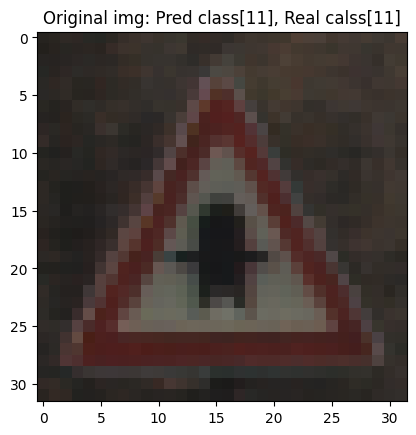

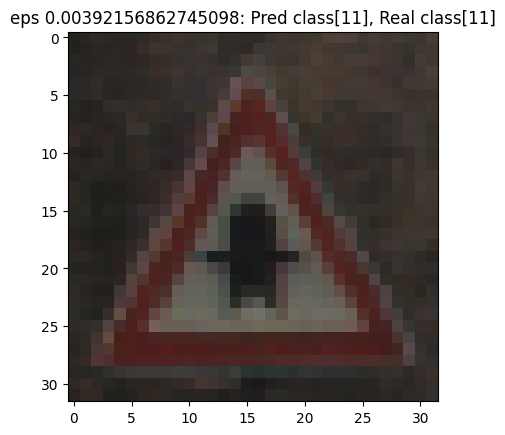

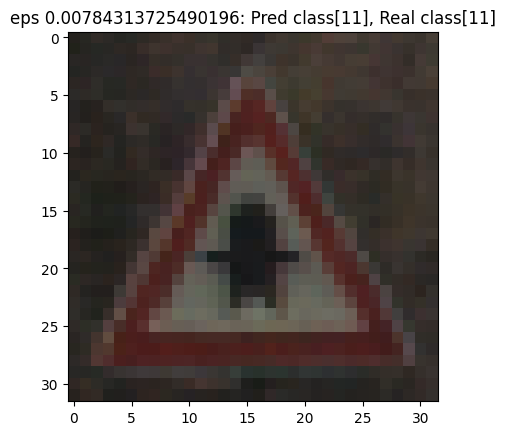

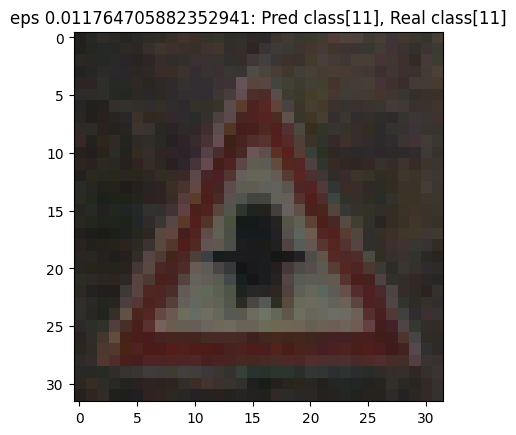

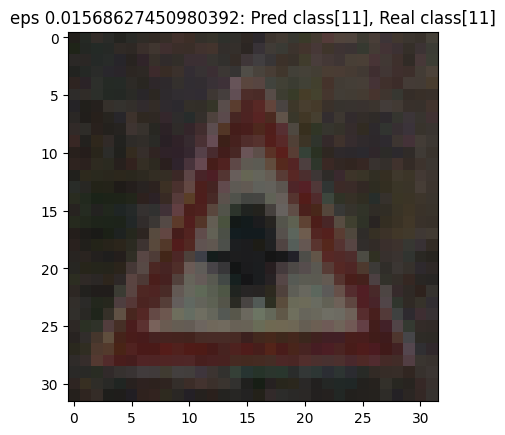

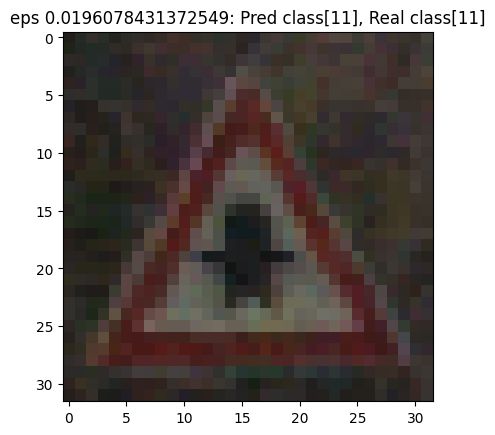

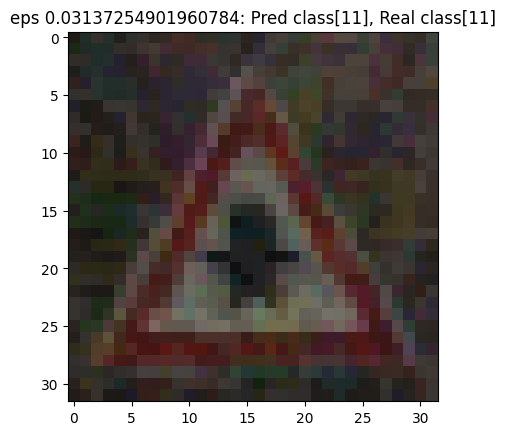

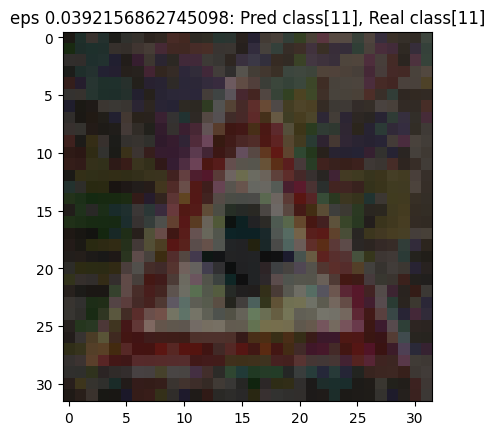

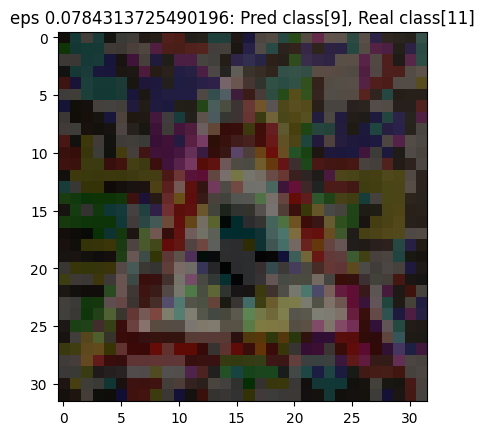

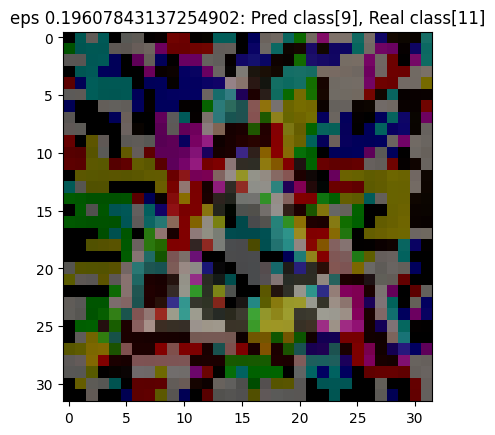

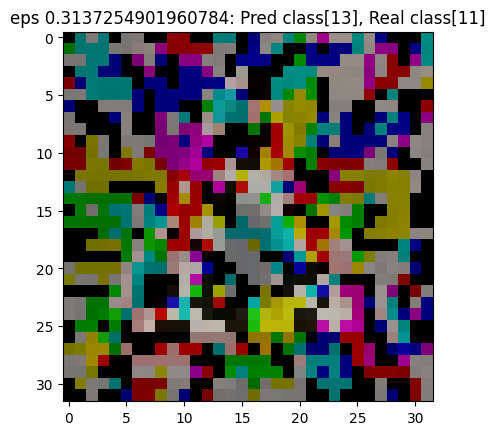

In [34]:
# отображаем исходные и адверсариальные изображения для разных значений eps
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(4)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

# проходимся по каждому eps из заданного диапазона
for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

In [35]:
# создаем атаку PGD
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = [] # для точности оригинальных данных
adv_accuracises_pgd = []
true_losses = [] # для потерь на оригинальных данных
adv_losses_pgd = []

In [36]:
# пройдемся диапазону значений eps
for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_pgd.append(accuracy)
    adv_losses_pgd.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
Adv Loss: 1.29585533618927
Adv Accuracy: 0.7689999938011169
True Loss: 0.29480318588018417
True Accuracy: 0.9279999732971191
Eps: 0.00784313725490196
Adv Loss: 2.593485978126526
Adv Accuracy: 0.5740000009536743
True Loss: 0.29480318588018417
True Accuracy: 0.9279999732971191
Eps: 0.011764705882352941
Adv Loss: 3.675563621520996
Adv Accuracy: 0.4569999873638153
True Loss: 0.29480318588018417
True Accuracy: 0.9279999732971191
Eps: 0.01568627450980392
Adv Loss: 4.613711967468261
Adv Accuracy: 0.39100000262260437
True Loss: 0.29480318588018417
True Accuracy: 0.9279999732971191
Eps: 0.0196078431372549
Adv Loss: 5.019875970840454
Adv Accuracy: 0.3659999966621399
True Loss: 0.29480318588018417
True Accuracy: 0.9279999732971191
Eps: 0.03137254901960784
Adv Loss: 6.3507663497924804
Adv Accuracy: 0.2709999978542328
True Loss: 0.29480318588018417
True Accuracy: 0.9279999732971191
Eps: 0.0392156862745098
Adv Loss: 6.752316040039062
Adv Accuracy: 0.25
True Loss: 0.294803185

In [37]:
# сохраним атаку PGD для дальнейшего анализа с помощью графика
adv_losses_pgd = np.array(adv_losses_pgd)
adv_accuracises_pgd = np.array(adv_accuracises_pgd)
np.save("adv_losses_pgd_ResNet50", adv_losses_pgd)
np.save("adv_accuracises_pgd_ResNet50", adv_accuracises_pgd)

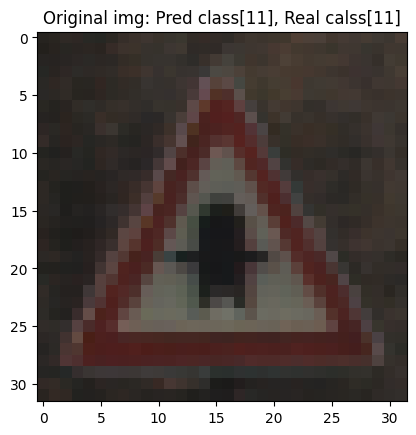

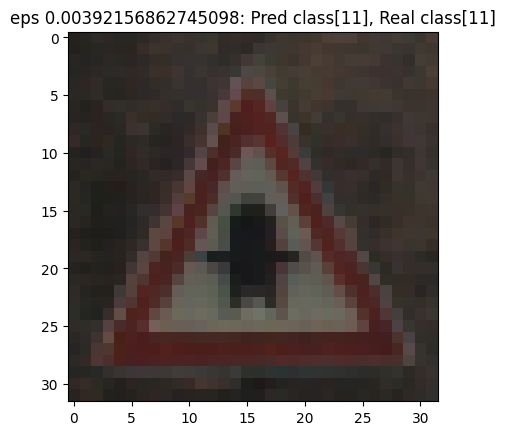

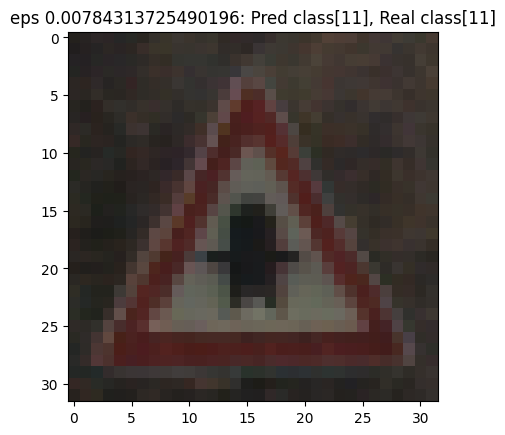

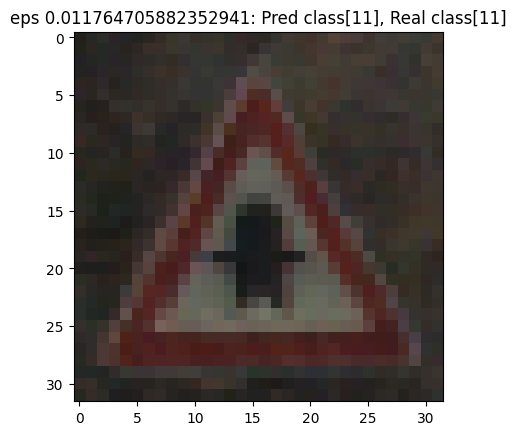

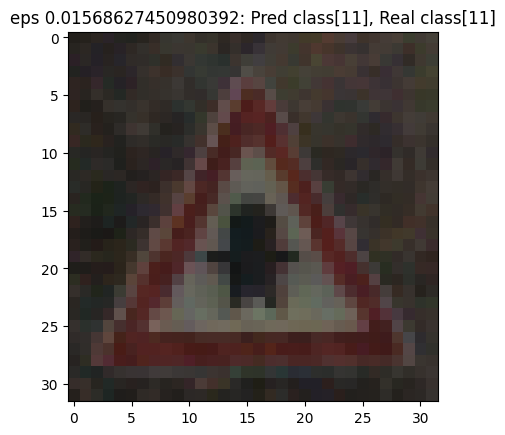

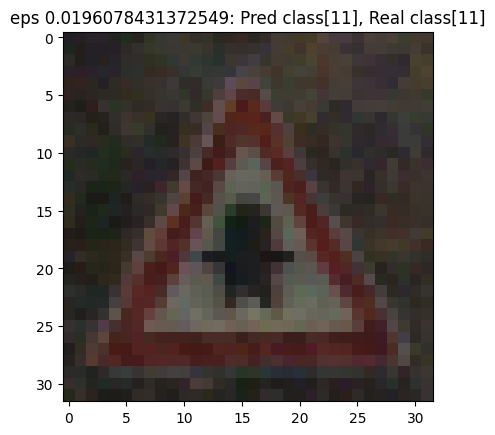

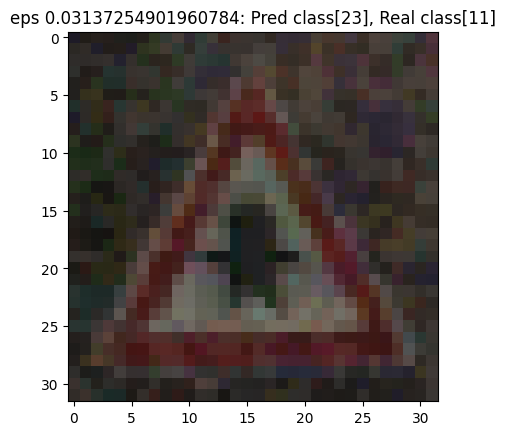

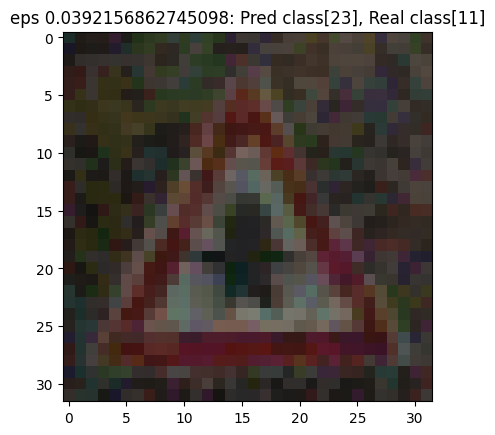

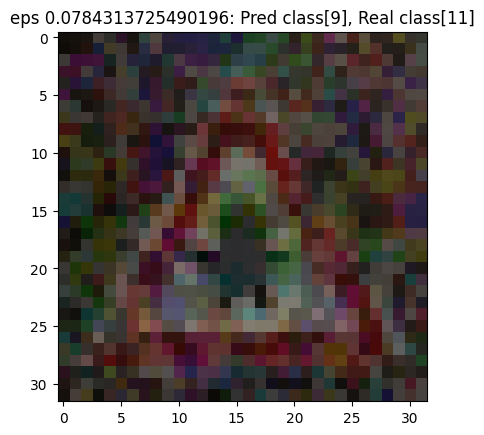

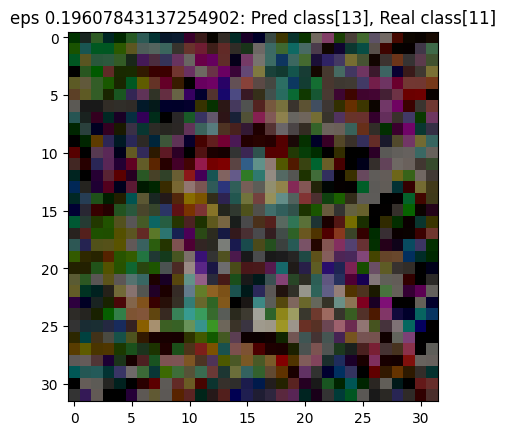

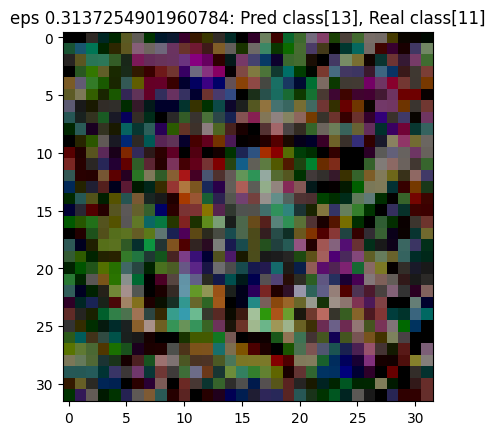

In [38]:
# отображаем исходные и адверсариальные изображения для разных значений eps
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(4)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1
# проходимся по каждому eps из заданного диапазона
for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    x_test_adv = attack_pgd.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

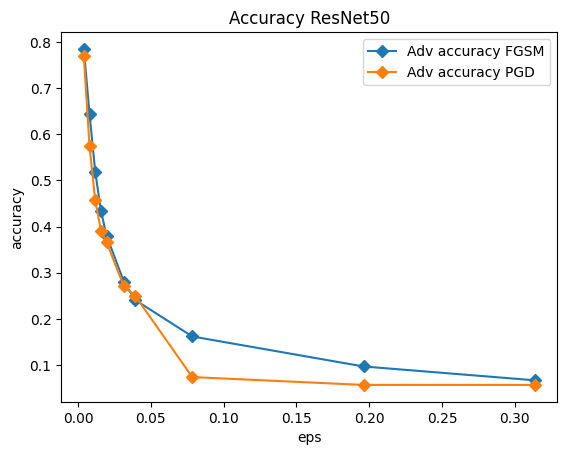

In [39]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
# загружаем ранее сохраненный массив адвирсариальных точностей для атак
# FGSM и PDG
adv_accuracises_fgsm = np.load("adv_accuracises_fgsm_ResNet50.npy")
adv_accuracises_pgd = np.load("adv_accuracises_pgd_ResNet50.npy")
# строим график зависимости адверсариальной точности от значения eps
# для атак PDG и FGSM
plt.figure(0)
plt.plot(eps_range, adv_accuracises_fgsm, label="Adv accuracy FGSM", marker='D')
plt.plot(eps_range, adv_accuracises_pgd, label="Adv accuracy PGD", marker='D')
plt.title("Accuracy ResNet50")
plt.xlabel("eps")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [40]:
# реализуем атаку FGSM для модели VGG16, которую сохраняли в первом задании
tf.compat.v1.disable_eager_execution()
model=load_model('VGG16.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))

In [41]:
# создаем атаку FGSM по аналогии с VGG16
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.3)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = [] # для точности оригинальных данных
adv_accuracises_fgsm = []
true_losses = [] # для потерь на оригинальных данных
adv_losses_fgsm = []

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_fgsm.append(accuracy)
    adv_losses_fgsm.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
Adv Loss: 0.953435531616211
Adv Accuracy: 0.8069999814033508
True Loss: 0.2868687395453453
True Accuracy: 0.9330000281333923
Eps: 0.00784313725490196
Adv Loss: 1.5565349273681641
Adv Accuracy: 0.7210000157356262
True Loss: 0.2868687395453453
True Accuracy: 0.9330000281333923
Eps: 0.011764705882352941
Adv Loss: 2.083909692764282
Adv Accuracy: 0.6330000162124634
True Loss: 0.2868687395453453
True Accuracy: 0.9330000281333923
Eps: 0.01568627450980392
Adv Loss: 2.512592350959778
Adv Accuracy: 0.578000009059906
True Loss: 0.2868687395453453
True Accuracy: 0.9330000281333923
Eps: 0.0196078431372549
Adv Loss: 2.8776816654205324
Adv Accuracy: 0.5419999957084656
True Loss: 0.2868687395453453
True Accuracy: 0.9330000281333923
Eps: 0.03137254901960784
Adv Loss: 3.651848293304443
Adv Accuracy: 0.46000000834465027
True Loss: 0.2868687395453453
True Accuracy: 0.9330000281333923
Eps: 0.0392156862745098
Adv Loss: 3.9369673252105715
Adv Accuracy: 0.42800000309944153
True Loss: 

In [42]:
# сохраним атаку FGSM для дальнейшего анализа с помощью графика
adv_losses_fgsm = np.array(adv_losses_fgsm)
adv_accuracises_fgsm = np.array(adv_accuracises_fgsm)
np.save("adv_losses_fgsm_VGG16", adv_losses_fgsm)
np.save("adv_accuracises_fgsm_VGG16", adv_accuracises_fgsm)

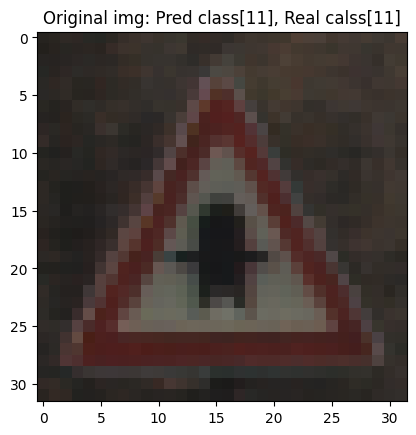

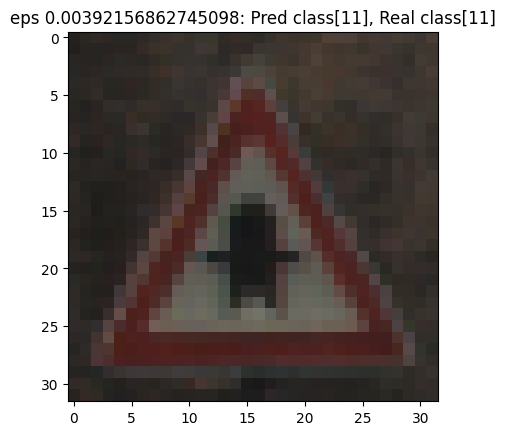

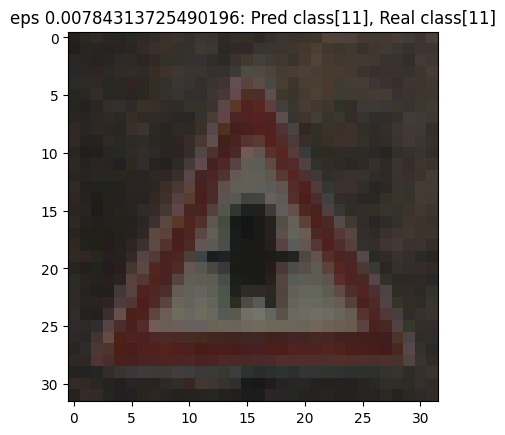

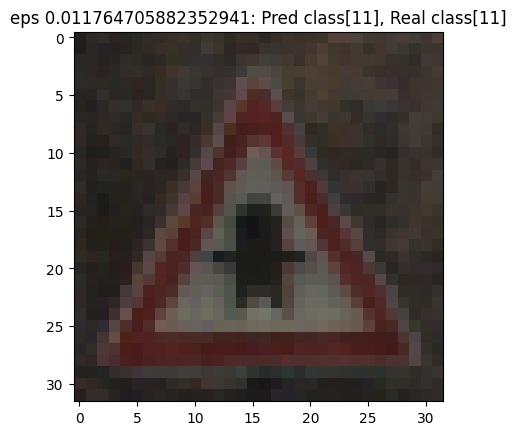

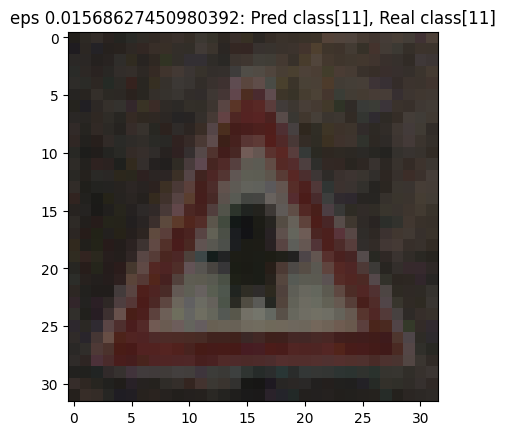

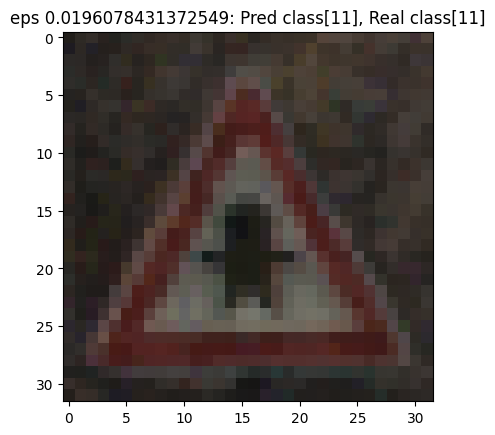

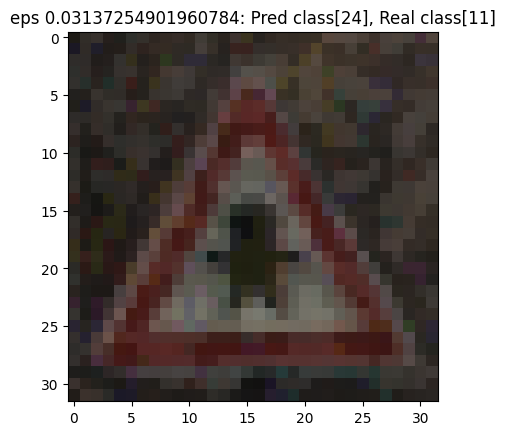

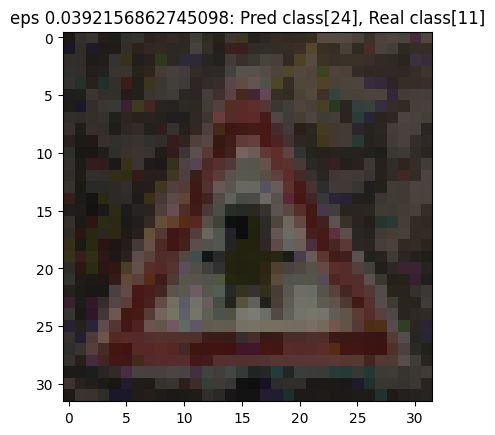

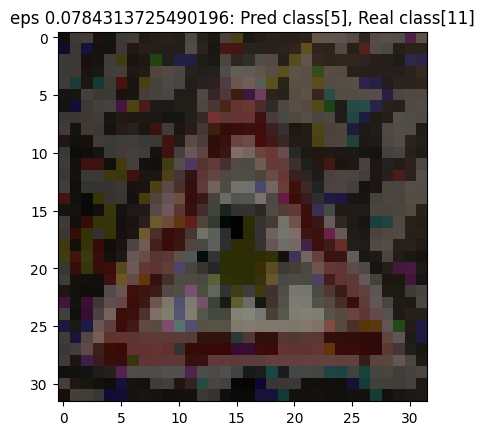

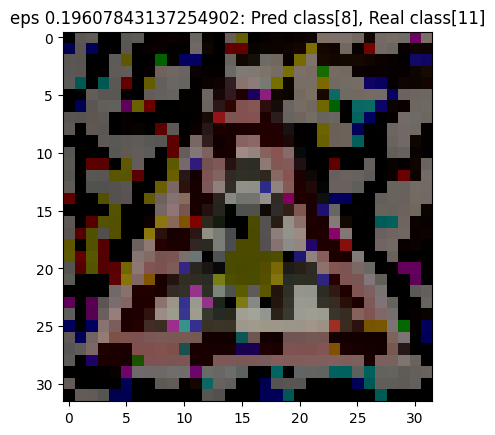

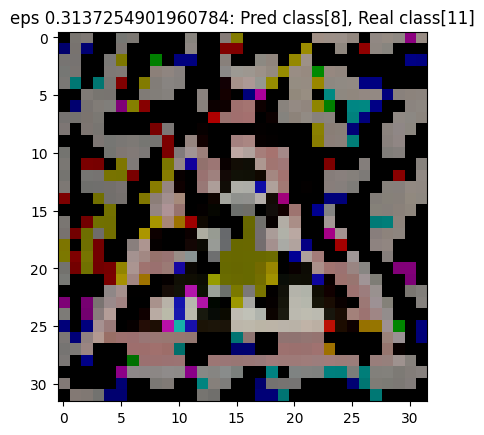

In [43]:
# отображаем исходные и адверсариальные изображения для разных значений eps
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(0)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1
# проходимся по каждому eps из заданного диапазона
for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    x_test_adv = attack_fgsm.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

In [44]:
# реализуем атаку PGD для модели VGG16
tf.compat.v1.disable_eager_execution()
model=load_model('VGG16.h5')
x_test = data[:1000]
y_test = y_test[:1000]
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))

In [45]:
# создаем атаку PGD по аналогии с ResNet50
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
true_accuracies = [] # для точности оригинальных данных
adv_accuracises_pgd = []
true_losses = [] # для потерь на оригинальных данных
adv_losses_pgd = []

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, y_test)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    adv_accuracises_pgd.append(accuracy)
    adv_losses_pgd.append(loss)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    true_accuracies.append(accuracy)
    true_losses.append(loss)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
Adv Loss: 1.0756173982620238
Adv Accuracy: 0.7919999957084656
True Loss: 0.2868687395453453
True Accuracy: 0.9330000281333923
Eps: 0.00784313725490196
Adv Loss: 1.7406605863571167
Adv Accuracy: 0.7009999752044678
True Loss: 0.2868687395453453
True Accuracy: 0.9330000281333923
Eps: 0.011764705882352941
Adv Loss: 2.46925039768219
Adv Accuracy: 0.6140000224113464
True Loss: 0.2868687395453453
True Accuracy: 0.9330000281333923
Eps: 0.01568627450980392
Adv Loss: 3.0384154434204103
Adv Accuracy: 0.5699999928474426
True Loss: 0.2868687395453453
True Accuracy: 0.9330000281333923
Eps: 0.0196078431372549
Adv Loss: 3.4827685737609864
Adv Accuracy: 0.5419999957084656
True Loss: 0.2868687395453453
True Accuracy: 0.9330000281333923
Eps: 0.03137254901960784
Adv Loss: 4.127380628585815
Adv Accuracy: 0.453000009059906
True Loss: 0.2868687395453453
True Accuracy: 0.9330000281333923
Eps: 0.0392156862745098
Adv Loss: 4.444550014495849
Adv Accuracy: 0.414000004529953
True Loss: 0.2

In [46]:
# сохраним атаку PGD для дальнейшего анализа с помощью графика
adv_losses_pgd = np.array(adv_losses_pgd)
adv_accuracises_pgd = np.array(adv_accuracises_pgd)
np.save("adv_losses_pgd_VGG16", adv_losses_pgd)
np.save("adv_accuracises_pgd_VGG16", adv_accuracises_pgd)

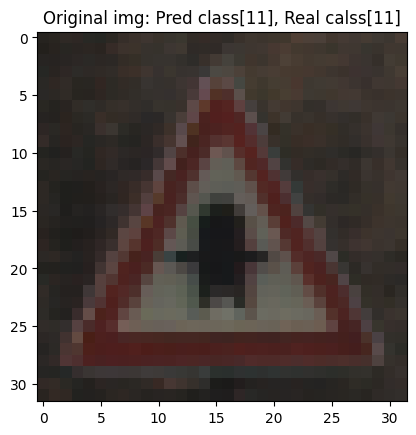

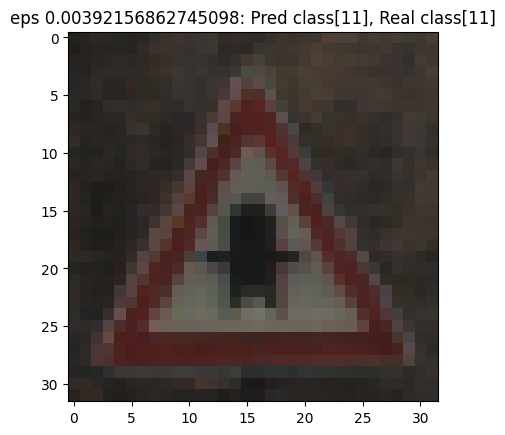

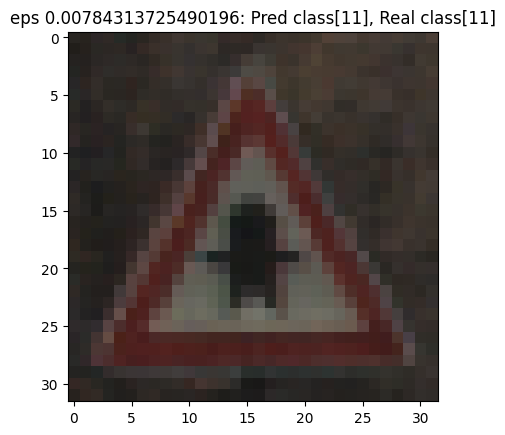

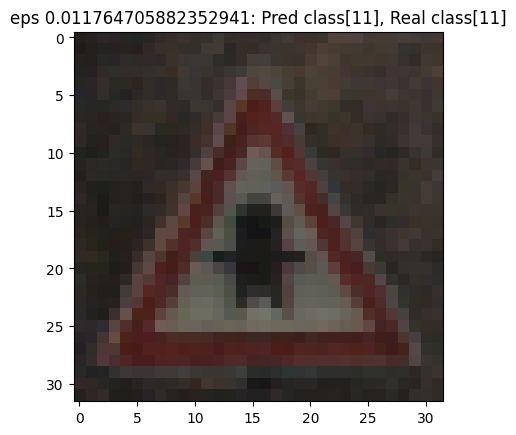

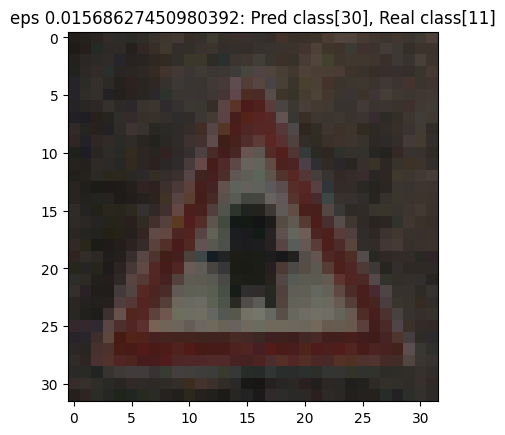

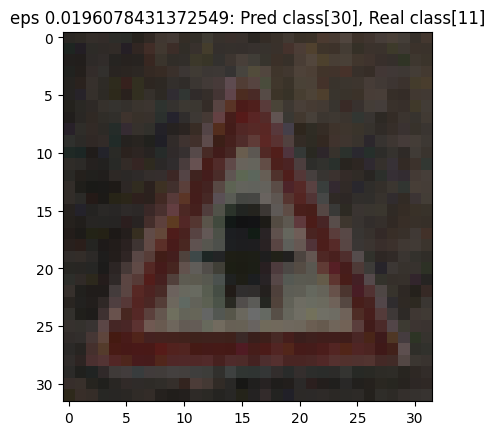

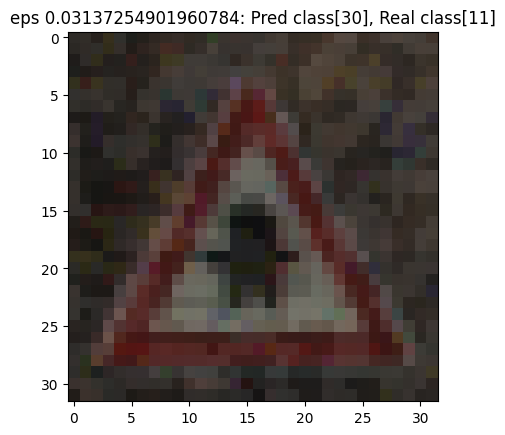

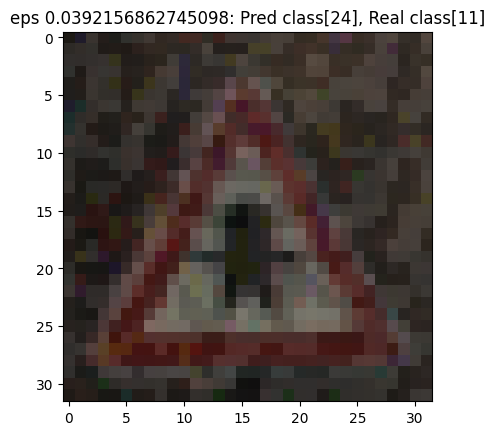

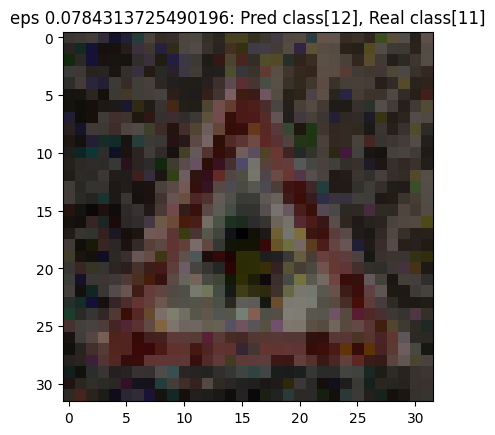

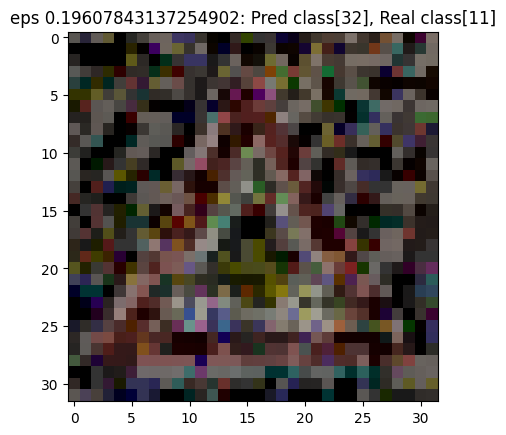

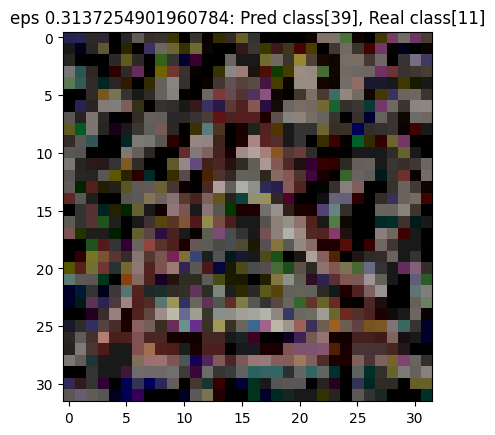

In [47]:
# отображаем исходные и адверсариальные изображения для разных значений eps
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
pred = np.argmax(model.predict(x_test[4:5]))
plt.figure(0)
plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[4])}]")
plt.imshow(x_test[4])
plt.show()
i = 1

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    x_test_adv = attack_pgd.generate(x_test, y_test)
    pred = np.argmax(model.predict(x_test_adv[4:5]))
    plt.figure(i)
    plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[4])}]")
    plt.imshow(x_test_adv[4])
    plt.show()
    i += 1

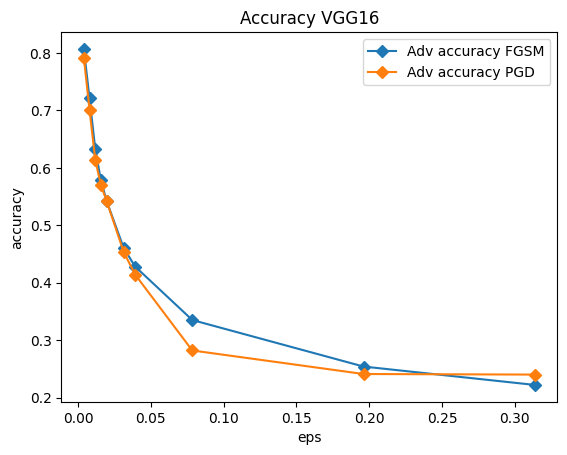

In [48]:
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]
# загружаем ранее сохраненный массив адвирсариальных точностей для атак FGSM и PGD
adv_accuracises_fgsm = np.load("adv_accuracises_fgsm_VGG16.npy")
adv_accuracises_pgd = np.load("adv_accuracises_pgd_VGG16.npy")
# график зависимости адверсариальной точности от значения eps для атак PGD и FGSM
plt.figure(0)
plt.plot(eps_range, adv_accuracises_fgsm, label="Adv accuracy FGSM", marker='D')
plt.plot(eps_range, adv_accuracises_pgd, label="Adv accuracy PGD", marker='D')
plt.title("Accuracy VGG16")
plt.xlabel("eps")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [49]:
# создадим таблицу со значениями точности для обеих моделей
adv_acc_fgsm_rn50 = np.load("adv_accuracises_fgsm_ResNet50.npy")
adv_acc_pgd_rn50 = np.load("adv_accuracises_pgd_ResNet50.npy")
adv_acc_fgsm_v16 = np.load("adv_accuracises_fgsm_VGG16.npy")
adv_acc_pgd_v16 = np.load("adv_accuracises_pgd_VGG16.npy")

table = [["Model","Original accuracy","eps = 1/255","eps = 2/255", "eps = 3/255", "eps = 4/255", "eps = 5/255", "eps = 8/255", "eps = 10/255", "eps = 20/255", "eps = 50/255", "eps = 80/255" ],
            ["Resnet50 FGSM",train_accuracy[4]*100,adv_acc_fgsm_rn50[0]*100,
             adv_acc_fgsm_rn50[1]*100,adv_acc_fgsm_rn50[2]*100,adv_acc_fgsm_rn50[3]*100,
             adv_acc_fgsm_rn50[4]*100,adv_acc_fgsm_rn50[5]*100,adv_acc_fgsm_rn50[6]*100,
             adv_acc_fgsm_rn50[7]*100,adv_acc_fgsm_rn50[8]*100,adv_acc_fgsm_rn50[9]*100],
            ["Resnet50 PGD",train_accuracy[4]*100,adv_acc_pgd_rn50[0]*100,
             adv_acc_pgd_rn50[1]*100,adv_acc_pgd_rn50[2]*100,adv_acc_pgd_rn50[3]*100,
             adv_acc_pgd_rn50[4]*100,adv_acc_pgd_rn50[5]*100,adv_acc_pgd_rn50[6]*100,
             adv_acc_pgd_rn50[7]*100,adv_acc_pgd_rn50[8]*100,adv_acc_pgd_rn50[9]*100],
            ["VGG16 FGSM",train_accuracy2[4]*100,adv_acc_fgsm_v16[0]*100,
             adv_acc_fgsm_v16[1]*100,adv_acc_fgsm_v16[2]*100,adv_acc_fgsm_v16[3]*100,
             adv_acc_fgsm_v16[4]*100,adv_acc_fgsm_v16[5]*100,adv_acc_fgsm_v16[6]*100,
             adv_acc_fgsm_v16[7]*100,adv_acc_fgsm_v16[8]*100,adv_acc_fgsm_v16[9]*100],
            ["VGG16 PGD",train_accuracy2[4]*100,adv_acc_pgd_v16[0]*100,
             adv_acc_pgd_v16[1]*100,adv_acc_pgd_v16[2]*100,adv_acc_pgd_v16[3]*100,
             adv_acc_pgd_v16[4]*100,adv_acc_pgd_v16[5]*100,adv_acc_pgd_v16[6]*100,
             adv_acc_pgd_v16[7]*100,adv_acc_pgd_v16[8]*100,adv_acc_pgd_v16[9]*100],
         ]

table2 = tabulate(table,headers="firstrow",tablefmt="grid")
print(table2)

+---------------+---------------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+----------------+----------------+
| Model         |   Original accuracy |   eps = 1/255 |   eps = 2/255 |   eps = 3/255 |   eps = 4/255 |   eps = 5/255 |   eps = 8/255 |   eps = 10/255 |   eps = 20/255 |   eps = 50/255 |   eps = 80/255 |
+===============+=====================+===============+===============+===============+===============+===============+===============+================+================+================+================+
| Resnet50 FGSM |             97.2783 |          78.5 |          64.4 |          51.9 |          43.4 |          38   |          28.1 |           24.1 |           16.2 |            9.7 |            6.7 |
+---------------+---------------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+---------------

**ЗАДАНИЕ 3**

In [50]:
# создадим две целевых атаки
# загружаем тестовый набор данных из Test.csv и извлекаем изображения с меткой 14
# Преобразуем изображения в массив чисел и нормализуем
test = pd.read_csv("Test.csv")
test_imgs = test['Path'].values
data = []
y_test = []
labels = test['ClassId'].values.tolist()
i = -1

for img in test_imgs:
    i += 1
    if labels[i] != 14:
      continue
    img = image.load_img(img, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = img_array /255
    data.append(img_array)
    y_test.append(labels[i])
data = np.array(data)
y_test = np.array(y_test)
y_test = to_categorical(y_test, 43)

In [51]:
# реализуем целевую атаку FGSM
model=load_model('ResNet50.h5')
tf.compat.v1.disable_eager_execution()
t_class = 1
t_class = to_categorical(t_class, 43)
t_classes = np.tile(t_class, (270, 1))
x_test = data
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))
attack_fgsm = FastGradientMethod(estimator=classifier, eps=0.2, targeted=True, batch_size=64)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]

for eps in eps_range:
    attack_fgsm.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_fgsm.generate(x_test, t_classes)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Adv Loss: 0.1903334829542372
Adv Accuracy: 0.9333333373069763
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.00784313725490196
Adv Loss: 0.7337295505735609
Adv Accuracy: 0.8296296000480652
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.011764705882352941
Adv Loss: 1.4126831981870862
Adv Accuracy: 0.699999988079071
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.01568627450980392
Adv Loss: 2.027206125965825
Adv Accuracy: 0.6222222447395325
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.0196078431372549
Adv Loss: 2.5781511377405235
Adv Accuracy: 0.5259259343147278
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.03137254901960784
Adv Loss: 4.070250196810122
Adv Accuracy: 0.27037036418914795
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.0392156862745098
Adv Loss: 4.889040717372188
Adv Accuracy: 0.14074073731899261
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.0784313725490196
Adv Loss: 6.283584997389052
Adv Accuracy: 0.0

In [52]:
# лучше всего себя показывает 10/255
eps = 10/255
attack_fgsm.set_params(**{'eps': eps})
x_test_adv = attack_fgsm.generate(x_test, t_classes)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


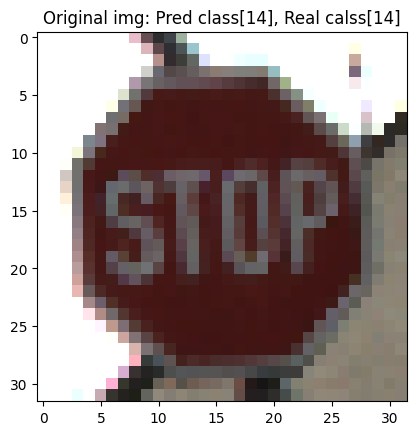

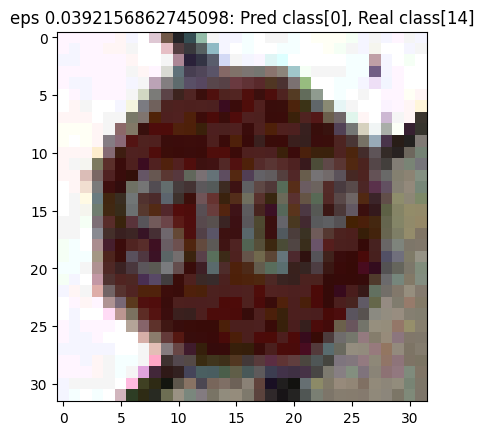

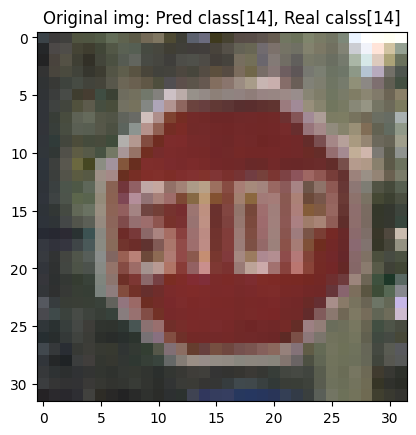

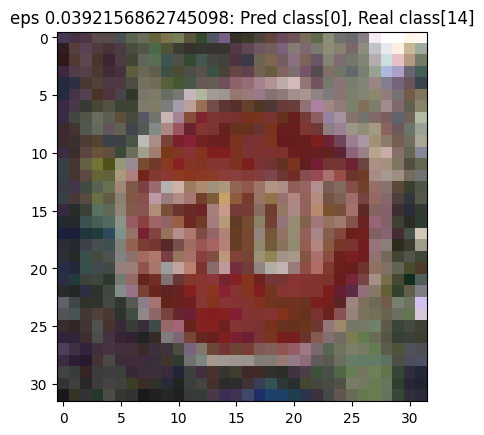

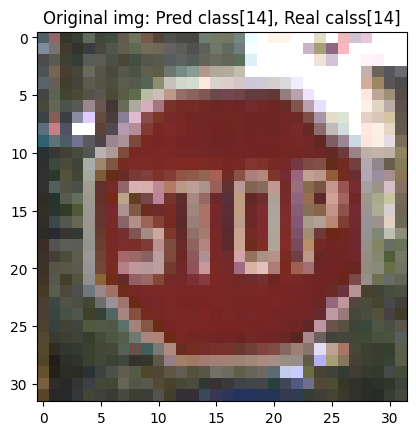

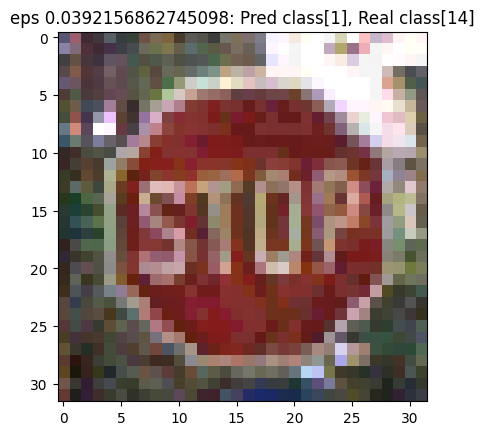

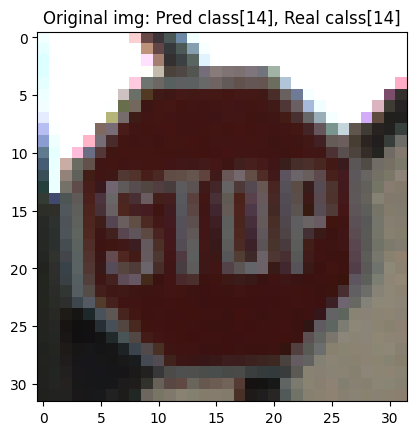

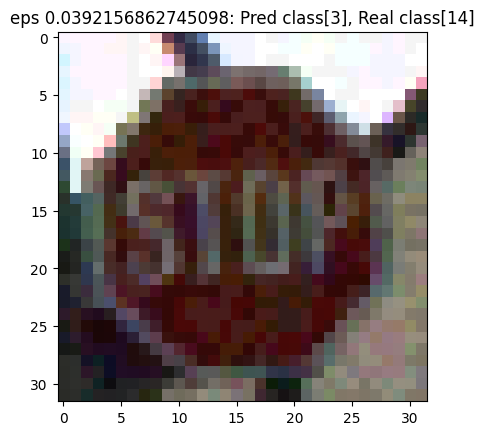

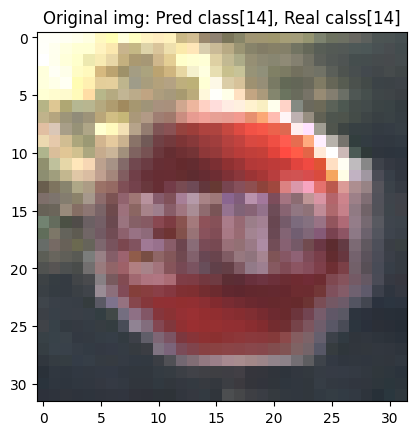

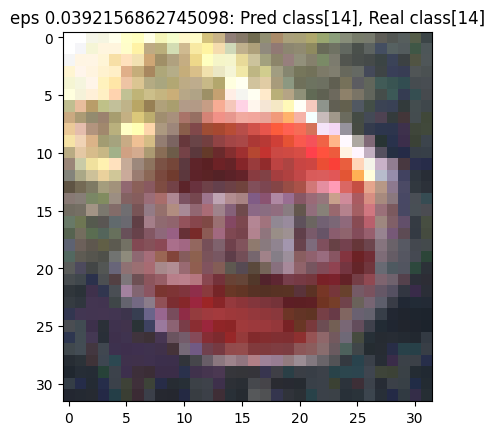

In [53]:
# отобразим 5 разных изображений для визуализации действия атаки
range = [0, 10, 20, 30, 40]
i = 0
for index in range:
  plt.figure(i)
  pred = np.argmax(model.predict(x_test[index:index+1]))
  plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[index])}]")
  plt.imshow(x_test[index])
  plt.show()
  i += 1
  pred = np.argmax(model.predict(x_test_adv[index:index+1]))
  plt.figure(i)
  plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[index])}]")
  plt.imshow(x_test_adv[index])
  plt.show()

In [54]:
# реализуем целевую атаку PGD
# сгенерируем адверсариальные примеры и оценим точность модели на адвирсариальных
# примерах и на исходных тестовых данных
model=load_model('ResNet50.h5')
classifier = KerasClassifier(model=model, clip_values=(np.min(x_test), np.max(x_test)))
attack_pgd = ProjectedGradientDescent(estimator=classifier, eps=0.3, max_iter=4, verbose=False, targeted=True)
eps_range = [1/255, 2/255, 3/255, 4/255, 5/255, 8/255, 10/255, 20/255, 50/255, 80/255]

for eps in eps_range:
    attack_pgd.set_params(**{'eps': eps})
    print(f"Eps: {eps}")
    x_test_adv = attack_pgd.generate(x_test, t_classes)
    loss, accuracy = model.evaluate(x_test_adv, y_test)
    print(f"Adv Loss: {loss}")
    print(f"Adv Accuracy: {accuracy}")
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"True Loss: {loss}")
    print(f"True Accuracy: {accuracy}")

Eps: 0.00392156862745098
Adv Loss: 0.036004904823170765
Adv Accuracy: 0.9925925731658936
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.00784313725490196
Adv Loss: 0.17419385303294768
Adv Accuracy: 0.9518518447875977
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.011764705882352941
Adv Loss: 0.4537421532251217
Adv Accuracy: 0.8925926089286804
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.01568627450980392
Adv Loss: 0.6652887706403379
Adv Accuracy: 0.8703703880310059
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.0196078431372549
Adv Loss: 1.0136789577978629
Adv Accuracy: 0.7740740776062012
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.03137254901960784
Adv Loss: 2.255227522496824
Adv Accuracy: 0.614814817905426
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.0392156862745098
Adv Loss: 3.0106800529691906
Adv Accuracy: 0.5518518686294556
True Loss: 0.00491397607703995
True Accuracy: 1.0
Eps: 0.0784313725490196
Adv Loss: 7.28974

In [55]:
# играемся с параметрами eps
eps = 10/255
attack_pgd.set_params(**{'eps': eps})
x_test_adv = attack_pgd.generate(x_test, t_classes)

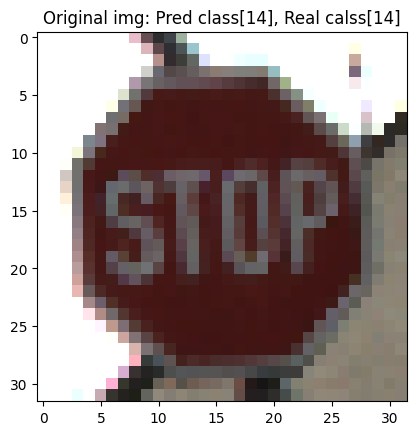

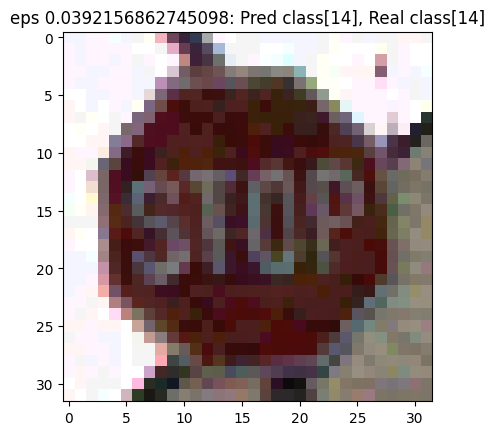

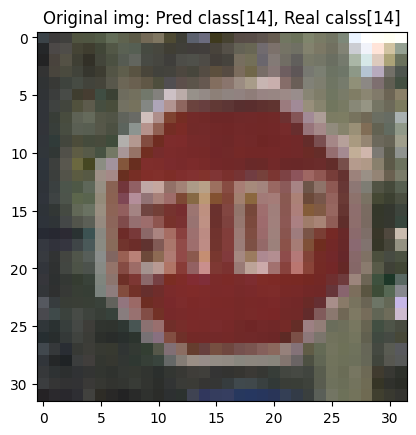

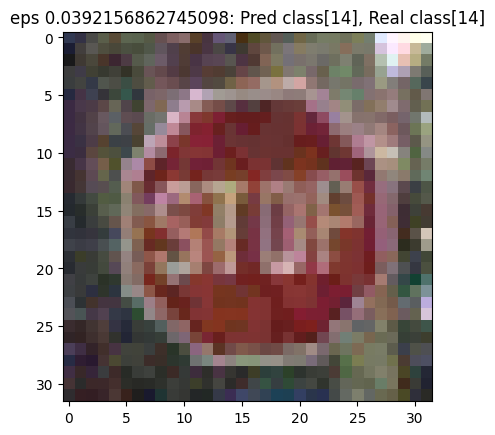

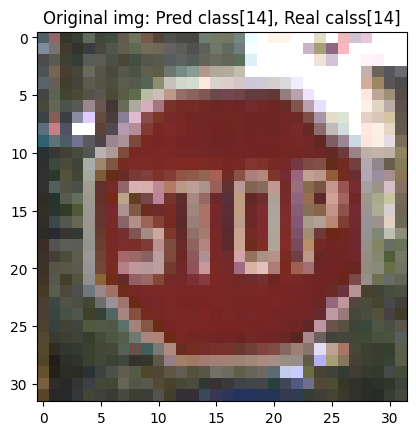

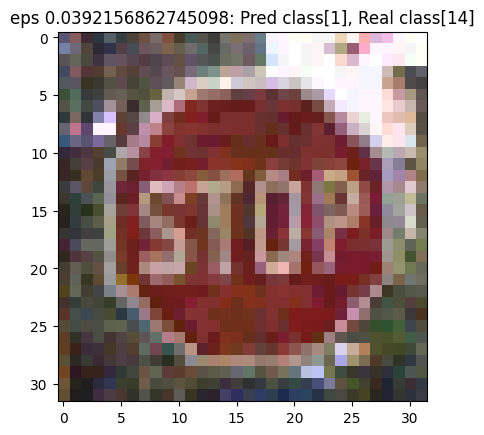

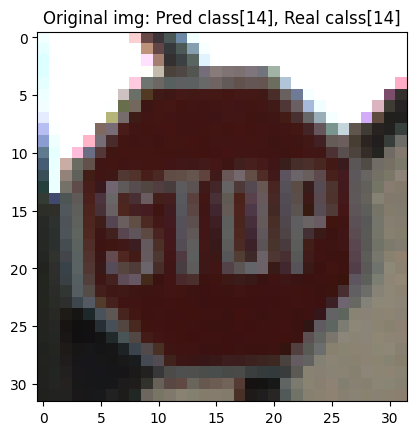

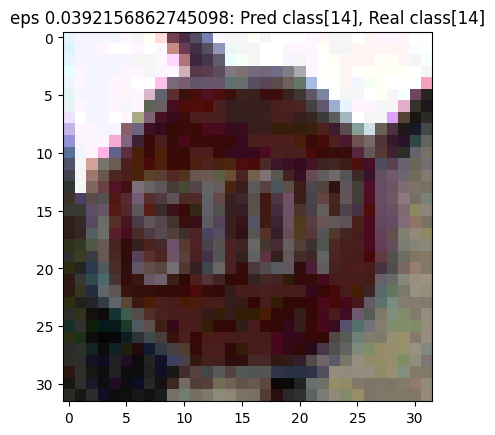

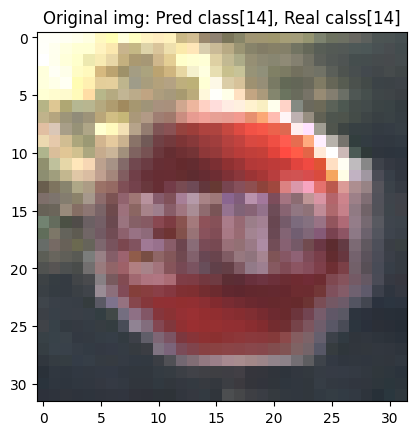

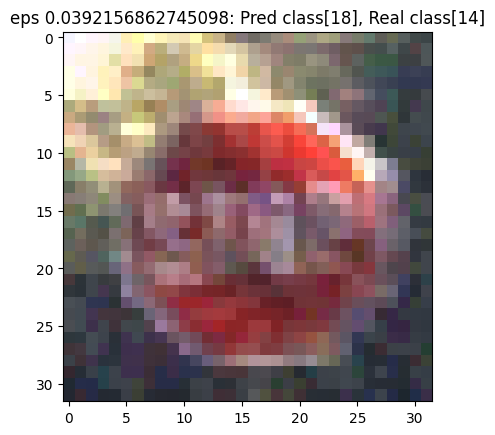

In [56]:
# отобразим 5 разных изображений для визуализации действия атаки
range = [0, 10, 20, 30, 40]
i = 0
for index in range:
  plt.figure(i)
  pred = np.argmax(model.predict(x_test[index:index+1]))
  plt.title(f"Original img: Pred class[{pred}], Real calss[{np.argmax(y_test[index])}]")
  plt.imshow(x_test[index])
  plt.show()
  i += 1
  pred = np.argmax(model.predict(x_test_adv[index:index+1]))
  plt.figure(i)
  plt.title(f"eps {eps}: Pred class[{pred}], Real class[{np.argmax(y_test[index])}]")
  plt.imshow(x_test_adv[index])
  plt.show()